In [2]:
from google.colab import files
uploaded = files.upload()

Saving cohorts.csv to cohorts.csv


In [3]:
import pandas as pd

# Load the dataset (adjust the path if needed)
df = pd.read_csv('cohorts.csv')

# Replace 'NA' with NaT (Not a Time) for date columns
df[['lead', 'phase2', 'phase3', 'closed']] = df[['lead', 'phase2', 'phase3', 'closed']].replace('NA', pd.NaT)

# Convert columns to datetime
df['lead'] = pd.to_datetime(df['lead'])
df['phase2'] = pd.to_datetime(df['phase2'])
df['phase3'] = pd.to_datetime(df['phase3'])
df['closed'] = pd.to_datetime(df['closed'])

# Create a cohort identifier based on the lead month
df['cohort_month'] = df['lead'].dt.to_period('M')

In [4]:
# Calculate total leads per cohort
cohort_counts = df.groupby('cohort_month').size().reset_index(name='total_leads')

# Calculate counts of leads reaching each stage
phase2_counts = df.groupby('cohort_month')['phase2'].count().reset_index(name='phase2_count')
phase3_counts = df.groupby('cohort_month')['phase3'].count().reset_index(name='phase3_count')
closed_counts = df.groupby('cohort_month')['closed'].count().reset_index(name='closed_count')

# Merge the counts
cohort_data = cohort_counts.merge(phase2_counts, on='cohort_month')
cohort_data = cohort_data.merge(phase3_counts, on='cohort_month')
cohort_data = cohort_data.merge(closed_counts, on='cohort_month')

# Calculate conversion rates
cohort_data['phase2_rate'] = cohort_data['phase2_count'] / cohort_data['total_leads'] * 100
cohort_data['phase3_rate'] = cohort_data['phase3_count'] / cohort_data['total_leads'] * 100
cohort_data['closed_rate'] = cohort_data['closed_count'] / cohort_data['total_leads'] * 100

# Display the results
print(cohort_data[['cohort_month', 'total_leads', 'phase2_rate', 'phase3_rate', 'closed_rate']])

   cohort_month  total_leads  phase2_rate  phase3_rate  closed_rate
0       2015-06          218    63.302752    63.302752    63.302752
1       2015-07          502    65.139442    65.139442    65.139442
2       2015-08          602    63.953488    63.953488    63.953488
3       2015-09          718    64.484680    64.484680    64.484680
4       2015-10          778    63.239075    63.239075    63.239075
5       2015-11          736    63.586957    63.586957    63.586957
6       2015-12          723    64.038728    64.038728    64.038728
7       2016-01         1109    62.578900    62.578900    62.578900
8       2016-02         1030    65.533981    65.339806    65.048544
9       2016-03         1112    63.219424    60.161871    56.924460
10      2016-04         1089    64.095500    41.414141    36.179982
11      2016-05         1122    31.194296     9.358289     7.754011
12      2016-06          544     6.801471     1.102941     1.102941


In [5]:
# Calculate time to close (in days)
df['time_to_close'] = (df['closed'] - df['lead']).dt.days

# Group by cohort_month and calculate the average time to close
time_to_close = df.groupby('cohort_month')['time_to_close'].mean().reset_index(name='avg_days_to_close')

# Display the results
print(time_to_close)

   cohort_month  avg_days_to_close
0       2015-06          54.623188
1       2015-07          54.862385
2       2015-08          53.563636
3       2015-09          56.092873
4       2015-10          58.004065
5       2015-11          57.405983
6       2015-12          54.334773
7       2016-01          58.236311
8       2016-02          62.200000
9       2016-03          56.881517
10      2016-04          43.812183
11      2016-05          25.000000
12      2016-06           6.500000


In [6]:
# Calculate the month difference between lead and each stage
df['months_to_phase2'] = ((df['phase2'].dt.year - df['lead'].dt.year) * 12 +
                          (df['phase2'].dt.month - df['lead'].dt.month))
df['months_to_phase3'] = ((df['phase3'].dt.year - df['lead'].dt.year) * 12 +
                          (df['phase3'].dt.month - df['lead'].dt.month))
df['months_to_closed'] = ((df['closed'].dt.year - df['lead'].dt.year) * 12 +
                          (df['closed'].dt.month - df['lead'].dt.month))

# Create a pivot table for each stage
cohort_pivot_phase2 = df.pivot_table(index='cohort_month', columns='months_to_phase2',
                                     aggfunc='size', fill_value=0)
cohort_pivot_phase3 = df.pivot_table(index='cohort_month', columns='months_to_phase3',
                                     aggfunc='size', fill_value=0)
cohort_pivot_closed = df.pivot_table(index='cohort_month', columns='months_to_closed',
                                     aggfunc='size', fill_value=0)

# Normalize by the total leads in each cohort to get percentages
cohort_pivot_phase2 = cohort_pivot_phase2.div(cohort_counts.set_index('cohort_month')['total_leads'], axis=0) * 100
cohort_pivot_phase3 = cohort_pivot_phase3.div(cohort_counts.set_index('cohort_month')['total_leads'], axis=0) * 100
cohort_pivot_closed = cohort_pivot_closed.div(cohort_counts.set_index('cohort_month')['total_leads'], axis=0) * 100

# Display the cohort tables
print("Phase 2 Cohort Table (% of leads reaching phase2 over time):")
print(cohort_pivot_phase2)
print("\nPhase 3 Cohort Table (% of leads reaching phase3 over time):")
print(cohort_pivot_phase3)
print("\nClosed Cohort Table (% of leads reaching closed over time):")
print(cohort_pivot_closed)

Phase 2 Cohort Table (% of leads reaching phase2 over time):
months_to_phase2        0.0        1.0        2.0       3.0
cohort_month                                               
2015-06            0.917431  30.275229  29.816514  2.293578
2015-07            4.980080  39.442231  20.119522  0.597610
2015-08            5.813953  35.382060  21.926910  0.830565
2015-09            6.267409  37.465181  20.334262  0.417827
2015-10            7.197943  37.017995  18.637532  0.385604
2015-11            8.288043  38.586957  16.304348  0.407609
2015-12            8.022130  42.461964  13.001383  0.553250
2016-01            8.476105  37.150586  16.230839  0.721371
2016-02            8.640777  42.135922  14.174757  0.582524
2016-03            9.712230  38.848921  14.388489  0.269784
2016-04           10.009183  43.342516  10.743802  0.000000
2016-05           11.319073  19.875223   0.000000  0.000000
2016-06            6.801471   0.000000   0.000000  0.000000

Phase 3 Cohort Table (% of leads reach

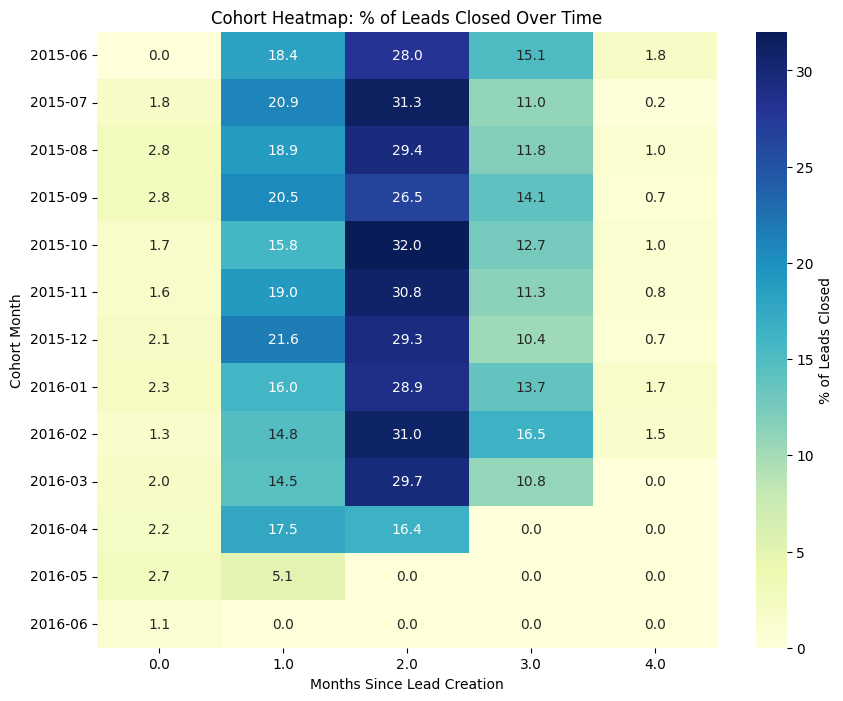

In [7]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming the closed cohort table is already calculated (from your previous output)
# Recreate the closed cohort table as a DataFrame
data = {
    '0.0': [0.0, 1.79, 2.82, 2.79, 1.67, 1.63, 2.07, 2.34, 1.26, 1.98, 2.20, 2.67, 1.10],
    '1.0': [18.35, 20.92, 18.94, 20.47, 15.81, 19.02, 21.58, 15.96, 14.85, 14.48, 17.54, 5.08, 0.0],
    '2.0': [27.98, 31.27, 29.40, 26.46, 32.01, 30.84, 29.32, 28.85, 30.97, 29.68, 16.44, 0.0, 0.0],
    '3.0': [15.14, 10.96, 11.79, 14.07, 12.72, 11.28, 10.37, 13.71, 16.50, 10.79, 0.0, 0.0, 0.0],
    '4.0': [1.83, 0.20, 1.00, 0.70, 1.03, 0.82, 0.69, 1.71, 1.46, 0.0, 0.0, 0.0, 0.0]
}
cohort_months = ['2015-06', '2015-07', '2015-08', '2015-09', '2015-10', '2015-11', '2015-12',
                 '2016-01', '2016-02', '2016-03', '2016-04', '2016-05', '2016-06']
closed_cohort = pd.DataFrame(data, index=cohort_months)

# Create the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(closed_cohort, annot=True, fmt=".1f", cmap="YlGnBu", cbar_kws={'label': '% of Leads Closed'})
plt.title('Cohort Heatmap: % of Leads Closed Over Time')
plt.xlabel('Months Since Lead Creation')
plt.ylabel('Cohort Month')
plt.savefig('cohort_heatmap.png')